## Imports and Miscellaneous

This code can be used to pip install seaborn in environments that don't have it available.

In [1]:
!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed, parallel_backend, parallel_config
from pathlib import Path
import time
import multiprocessing
import pickle
import json
import os
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

%config Application.warn_ignores = FutureWarning

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 16


## Notebook Start Time

In [3]:
notebook_start_time = time.time()

## Data

This function creates memory mapped files for the dataset, which is useful when using multiple processes to train multiple random forest classfiers  in parallel.

In [4]:
def create_mem_map(parquet_file, data_type='train'):

    df = pd.read_parquet(parquet_file)
    scaler = MinMaxScaler()

    mem_map_dir = Path('./mem_map_files')
    mem_map_dir.mkdir(exist_ok=True)

    mem_map_file_X = mem_map_dir/f'X_{data_type}.npy'
    mem_map_file_X_scaled = mem_map_dir/f'X_{data_type}_scaled.npy'
    mem_map_file_y_2 = mem_map_dir/f'y_{data_type}_2.npy'
    mem_map_file_y_6 = mem_map_dir/f'y_{data_type}_6.npy'
    mem_map_file_y_19 = mem_map_dir/f'y_{data_type}_19.npy'

    X = df.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
    np.save(mem_map_file_X, X)

    X_scaled = scaler.fit_transform(X)
    np.save(mem_map_file_X_scaled, X_scaled)

    encoder_2 = LabelEncoder()
    encoder_6 = LabelEncoder()
    encoder_19 = LabelEncoder()

    y_2 = encoder_2.fit_transform(df['class_label'])
    y_6 = encoder_6.fit_transform(df['category_label'])
    y_19 = encoder_19.fit_transform(df['attack_label'])

    np.save(mem_map_file_y_2, y_2)
    np.save(mem_map_file_y_6, y_6)
    np.save(mem_map_file_y_19, y_19)

    np.save(mem_map_dir/'encoder_2_classes.npy', encoder_2.classes_)
    np.save(mem_map_dir/'encoder_6_classes.npy', encoder_6.classes_)
    np.save(mem_map_dir/'encoder_19_classes.npy', encoder_19.classes_)

Set mem_map_created to False if you want to create the memory-mapped versions of the train and test datasets. Otherwise leave as True.

In [5]:
mem_map_created = True

if not mem_map_created:
    create_mem_map('./data/cic_iomt_2024_wifi_mqtt_train.parquet', data_type='train')
    create_mem_map('./data/cic_iomt_2024_wifi_mqtt_test.parquet', data_type='test')

This code loads the memory-mapped datasets. 

In [6]:
mem_map_dir = Path('./mem_map_files')
X_train = np.load(mem_map_dir/'X_train.npy', mmap_mode='r')

y_train_2 = np.load(mem_map_dir/'y_train_2.npy', mmap_mode='r')
y_train_6 = np.load(mem_map_dir/'y_train_6.npy', mmap_mode='r')
y_train_19 = np.load(mem_map_dir/'y_train_19.npy', mmap_mode='r')


X_test = np.load(mem_map_dir/'X_test.npy', mmap_mode='r')


y_test_2 = np.load(mem_map_dir/'y_test_2.npy', mmap_mode='r')
y_test_6 = np.load(mem_map_dir/'y_test_6.npy', mmap_mode='r')
y_test_19 = np.load(mem_map_dir/'y_test_19.npy', mmap_mode='r')

encoder_2_classes = np.load('./mem_map_files/encoder_2_classes.npy', allow_pickle=True)
encoder_6_classes = np.load('./mem_map_files/encoder_6_classes.npy', allow_pickle=True)
encoder_19_classes = np.load('./mem_map_files/encoder_19_classes.npy', allow_pickle=True)

This code is used to determine the number of features in the dataset.

In [7]:
n_features = X_train.shape[1]
print(f"Number of features: {n_features}")

Number of features: 45


## PSO Code

### Bio-inspired Function

This function is used to train a random forest classifier with set hyperparameters and random states to ensure reproducibility. It is used after PSO has determined the number of features to be used and the dataset passed to it will only contain those features. The number of classes used for the classification depends on the dataset being passed to the function and it assumes that these are consistent across y_train and y_test.

In [8]:
def calculate_bio_inspired(X_train=None, X_test=None, y_train=None, y_test=None):

    classifier = RandomForestClassifier(n_estimators=10, max_depth=15, n_jobs=-1, random_state=1984)

    # Calculate training time
    train_start = time.time()
    classifier.fit(X_train, y_train)
    train_end = time.time()

    # Calculate prediction/processing time
    pred_start = time.time()
    y_pred = classifier.predict(X_test)
    pred_end = time.time()


    if np.unique(y_train).size == 2:
         report = classification_report(encoder_2_classes[y_test], encoder_2_classes[y_pred], output_dict=True)
    elif np.unique(y_train).size == 6:
        report = classification_report(encoder_6_classes[y_test], encoder_6_classes[y_pred], output_dict=True)
    else:
        report = classification_report(encoder_19_classes[y_test], encoder_19_classes[y_pred], output_dict=True)

    return report, train_end - train_start, pred_end - pred_start, y_pred

### Fitness Function

This fitness function is used to determine the fitness value for each particle in the PSO implementation. The fucntion takes a "position" vector that has a 1 for each feature that is included in the subset to be used for the fitness calculation and a 0 for those not used. If you want fitness to use a mtric other than accuracy (e.g. f1-score), you can achieve this by adding it in place of accuracy and returning it instead of accuracy.  

In [9]:
def fitness_function(position, X_train, X_test, y_train, y_test):

    start_time_selection = time.time()
    selected_features = np.where(position == 1)[0]
    if len(selected_features) == 0:
        return 0
        
    # n_jobs is set to 1 because the code will be run in parallel using joblib.
    # Setting n_jobs to 1 and running it in parallel using joblib was found to be faster but if you decide to not use
    # parallel processing through joblib in the main PSO code, you can set n_jobs to -1 here.
    classifier = RandomForestClassifier(n_estimators=10, max_depth=15, n_jobs=1, random_state=1984)

    classifier.fit(X_train[:, selected_features], y_train)
    y_pred = classifier.predict(X_test[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

### PSO Feature Selection Function

This is the main PSO code. The code is set up to use the number cores as the number of particles, which worked well for us when using parallel processing but this value can be changed to suit your needs. max_same controls how many times in a row the global best accruacy after an iteration can improve by min_improvement or less compared to the prior global best before the code stops running. inertia_weight, cognitive_component, and social_component are the main PSO hyperparameters.

In [10]:
def pso_feature_selection(num_particles=num_cores, num_iterations=20, n_features=n_features, max_same=5, min_improvement=0.0001,
                          inertia_weight=0.5, cognitive_component=1.5, social_component=1.5,
                          X_train=None, X_test=None, y_train=None, y_test=None, parallel=True):

    # PSO Initialization Phase
    pso_start = time.time()
    init_start = time.time()
    np.random.seed(1984)
    velocity = np.zeros(shape=(num_particles, n_features))
    current_position = np.random.randint(2, size=(num_particles, n_features))

    if parallel is True:
        with parallel_backend('loky'):
            # can change verbose level to see more info on parallel processing progress
            current_fitness = np.array(Parallel(n_jobs=-1, batch_size=1, verbose=1)(delayed(fitness_function)(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])))
    else:
        current_fitness = np.array([fitness_function(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])])

    personal_best_position = np.copy(current_position)
    personal_best_fitness = np.copy(current_fitness)
    global_best_position = personal_best_position[np.argmax(personal_best_fitness)]
    global_best_fitness = np.max(personal_best_fitness)
    init_end = time.time()
    print(f"Initialization time: {(init_end - init_start)/60:.2f} minutes")

    # Main PSO Code
    small_improvement = 0
    for iteration in range(num_iterations):
        iteration_start = time.time()
        prior_global_best_fitness = np.copy(global_best_fitness)
        print(f"Iteration {iteration + 1}/{num_iterations}")

        if parallel is True:
            with parallel_backend('loky'):
                # can change verbose level to see more info on parallel processing progress
                current_fitness = np.array(Parallel(n_jobs=-1, batch_size=1, verbose=1)(delayed(fitness_function)(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])))
        else:
            current_fitness = np.array([fitness_function(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])])

        fitness_map = current_fitness > personal_best_fitness
        personal_best_fitness[fitness_map] = current_fitness[fitness_map]
        personal_best_position[fitness_map] = current_position[fitness_map]
        global_best_position = personal_best_position[np.argmax(personal_best_fitness)]
        global_best_fitness = np.max(personal_best_fitness)
        print(f"Global Best Fitness: {global_best_fitness:.4f}")

        if (global_best_fitness - prior_global_best_fitness) < min_improvement:
            small_improvement += 1
        else:
            small_improvement = 0

        if small_improvement >= max_same:
            iteration_end = time.time()
            pso_end = time.time()
            print(f"Iteration time: {(iteration_end - iteration_start)/60:.2f} minutes")
            return global_best_position, global_best_fitness, pso_end - pso_start

        # This part of the code uses the discrete binary version of PCO for updates to current position
        r1 = np.random.rand(num_particles, n_features)
        r2 = np.random.rand(num_particles, n_features)
        velocity = inertia_weight * velocity + cognitive_component * r1 * (personal_best_position - current_position) + social_component * r2 * (global_best_position - current_position)
        rand_nums = np.random.rand(num_particles, n_features)
        flip_probs = 1 / (1 + np.exp(-velocity))
        flip_map = rand_nums <= flip_probs
        current_position = np.where(flip_map, 1, 0)
        iteration_end = time.time()
        print(f"Iteration time: {(iteration_end - iteration_start)/60:.2f} minutes")

    pso_end = time.time()

    return global_best_position, global_best_fitness, pso_end - pso_start

#### Binary

In [11]:
rf_pso_best_pos_2, rf_pso_best_fitness_2, pso_algo_time_2 = pso_feature_selection(X_train=X_train, X_test=X_test,
                                                                                  y_train=y_train_2, y_test=y_test_2,
                                                                                  parallel=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Initialization time: 2.98 minutes
Iteration 1/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.1min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9989
Iteration time: 2.98 minutes
Iteration 2/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.7min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9989
Iteration time: 2.76 minutes
Iteration 3/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.6min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9989
Iteration time: 2.67 minutes
Iteration 4/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.33 minutes
Iteration 5/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.87 minutes
Iteration 6/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.4min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.76 minutes
Iteration 7/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.3min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.63 minutes
Iteration 8/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.5min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.71 minutes
Iteration 9/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.3min remaining:  8.9min


Global Best Fitness: 0.9991
Iteration time: 2.44 minutes


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished


In [12]:
print(f"PSO Algorithm Running Time: {pso_algo_time_2:.2f} seconds")

PSO Algorithm Running Time: 1627.02 seconds


In [13]:
rf_pso_features_2 = np.sum(rf_pso_best_pos_2)
selected_features = np.where(rf_pso_best_pos_2 == 1)[0]
rf_pso_report_2, rf_pso_train_time_2, rf_pso_pred_time_2, y_pred_rf_pso_2 = calculate_bio_inspired(X_train=X_train[:, selected_features],
                                                                                                   X_test=X_test[:, selected_features],
                                                                                                   y_train=y_train_2, y_test=y_test_2)
print(pd.DataFrame(rf_pso_report_2).transpose())
print(f"Training time: {rf_pso_train_time_2:.2f}")
print(f"Processing time: {rf_pso_pred_time_2:.2f}")

              precision    recall  f1-score       support
Attack         0.999777  0.999344  0.999560  1.576575e+06
Benign         0.972995  0.990640  0.981738  3.760700e+04
accuracy       0.999141  0.999141  0.999141  9.991414e-01
macro avg      0.986386  0.994992  0.990649  1.614182e+06
weighted avg   0.999153  0.999141  0.999145  1.614182e+06
Training time: 13.32
Processing time: 0.21


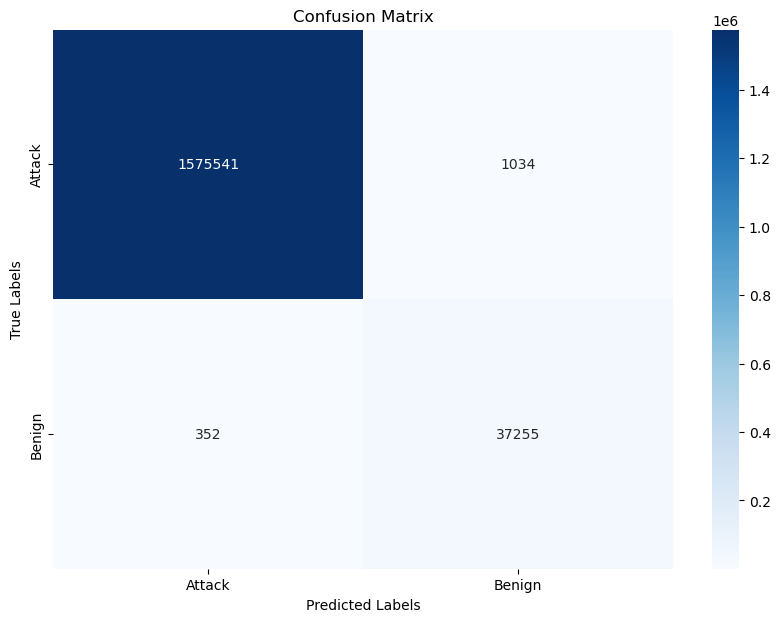

In [14]:
cm_rf_pso_2 = confusion_matrix(y_test_2, y_pred_rf_pso_2)

# get names for confusion matrix
df_2 = pd.DataFrame(rf_pso_report_2)
column_names_2 = df_2.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_pso_2,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_2,
            yticklabels=column_names_2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 6 Classes

In [15]:
rf_pso_best_pos_6, rf_pso_best_fitness_6, pso_algo_time_6 = pso_feature_selection(X_train=X_train, X_test=X_test,
                                                                                  y_train=y_train_6, y_test=y_test_6,
                                                                                  parallel=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.3min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Initialization time: 2.97 minutes
Iteration 1/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 3.00 minutes
Iteration 2/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.9min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.59 minutes
Iteration 3/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.7min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.71 minutes
Iteration 4/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.4min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.62 minutes
Iteration 5/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.5min remaining: 10.6min


Global Best Fitness: 0.9987
Iteration time: 2.72 minutes


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished


In [16]:
print(f"PSO Algorithm Running Time: {pso_algo_time_6:.2f} seconds")

PSO Algorithm Running Time: 996.37 seconds


In [17]:
rf_pso_features_6 = np.sum(rf_pso_best_pos_6)
selected_features = np.where(rf_pso_best_pos_6 == 1)[0]
rf_pso_report_6, rf_pso_train_time_6, rf_pso_pred_time_6, y_pred_rf_pso_6 = calculate_bio_inspired(X_train=X_train[:, selected_features],
                                                                                                   X_test=X_test[:, selected_features],
                                                                                                   y_train=y_train_6, y_test=y_test_6)
print(pd.DataFrame(rf_pso_report_6).transpose())
print(f"Training time: {rf_pso_train_time_6:.2f}")
print(f"Processing time: {rf_pso_pred_time_6:.2f}")

              precision    recall  f1-score       support
Benign         0.962406  0.995905  0.978869  3.760700e+04
DDos           0.999796  0.999962  0.999879  1.066764e+06
Dos            0.999897  0.999482  0.999689  4.166760e+05
MQTT           0.999937  0.992168  0.996037  6.371500e+04
Recon          0.993716  0.971275  0.982367  2.767600e+04
Spoofing       0.860735  0.765482  0.810319  1.744000e+03
accuracy       0.998690  0.998690  0.998690  9.986904e-01
macro avg      0.969414  0.954045  0.961193  1.614182e+06
weighted avg   0.998702  0.998690  0.998684  1.614182e+06
Training time: 14.62
Processing time: 0.43


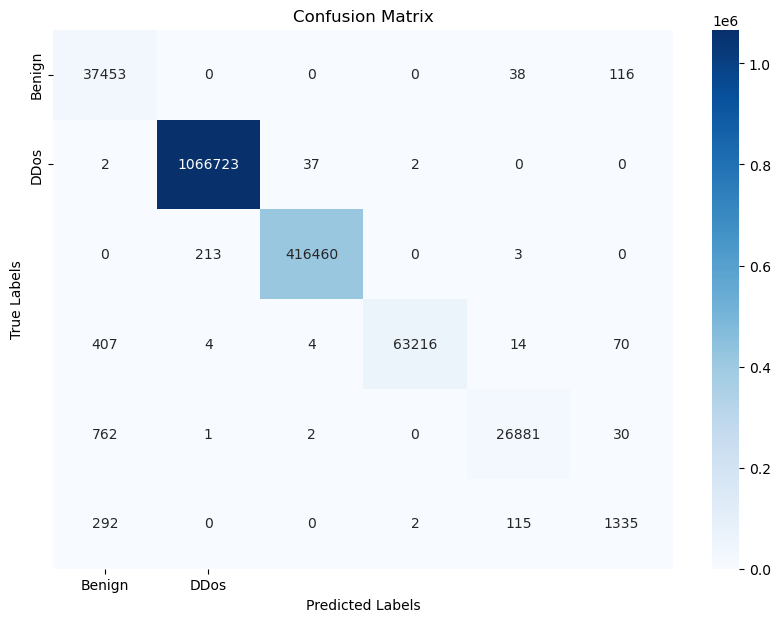

In [18]:
cm_rf_pso_6 = confusion_matrix(y_test_6, y_pred_rf_pso_6)

# get names for confusion matrix
df_6 = pd.DataFrame(rf_pso_report_6)
column_names_6 = df_6.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_pso_6,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_6,
            yticklabels=column_names_6)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 19 Classes

In [19]:
rf_pso_best_pos_19, rf_pso_best_fitness_19, pso_algo_time_19 = pso_feature_selection(X_train=X_train, X_test=X_test,
                                                                                     y_train=y_train_19, y_test=y_test_19,
                                                                                     parallel=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Initialization time: 2.70 minutes
Iteration 1/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.1min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9967
Iteration time: 2.72 minutes
Iteration 2/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.8min remaining: 12.3min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9972
Iteration time: 2.37 minutes
Iteration 3/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.4min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9972
Iteration time: 2.50 minutes
Iteration 4/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.4min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9972
Iteration time: 2.41 minutes
Iteration 5/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9972
Iteration time: 2.40 minutes
Iteration 6/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9972
Iteration time: 2.40 minutes
Iteration 7/20


[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:  1.3min remaining:  9.3min


Global Best Fitness: 0.9972
Iteration time: 2.54 minutes


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished


In [20]:
print(f"PSO Algorithm Running Time: {pso_algo_time_19:.2f} seconds")

PSO Algorithm Running Time: 1202.63 seconds


In [21]:
rf_pso_features_19 = np.sum(rf_pso_best_pos_19)
selected_features = np.where(rf_pso_best_pos_19 == 1)[0]
rf_pso_report_19, rf_pso_train_time_19, rf_pso_pred_time_19, y_pred_rf_pso_19 = calculate_bio_inspired(X_train=X_train[:, selected_features],
                                                                                                       X_test=X_test[:, selected_features],
                                                                                                       y_train=y_train_19, y_test=y_test_19)
print(pd.DataFrame(rf_pso_report_19).transpose())
print(f"Training time: {rf_pso_train_time_19:.2f}")
print(f"Processing time: {rf_pso_pred_time_19:.2f}")

                    precision    recall  f1-score       support
ARP_spoofing         0.850706  0.725344  0.783039  1.744000e+03
Benign               0.956682  0.994815  0.975376  3.760700e+04
DDoS_ICMP            0.999491  0.999911  0.999701  3.496990e+05
DDoS_SYN             0.999948  0.998097  0.999022  1.723970e+05
DDoS_TCP             0.999294  0.999956  0.999625  1.825980e+05
DDoS_UDP             0.999152  0.999586  0.999369  3.620700e+05
DDoS_connect_flood   0.999642  0.999976  0.999809  4.191600e+04
DDoS_publish_flood   0.999396  0.983484  0.991376  8.416000e+03
DoS_ICMP             0.999695  0.998933  0.999314  9.843200e+04
DoS_SYN              0.999757  0.999858  0.999807  9.859500e+04
DoS_TCP              0.999708  0.999890  0.999799  8.209600e+04
DoS_UDP              0.999593  0.999157  0.999375  1.375530e+05
DoS_connect_flood    1.000000  0.995529  0.997759  3.131000e+03
DoS_publish_flood    0.984603  1.000000  0.992242  8.505000e+03
Malformed_date       0.999197  0.712078 

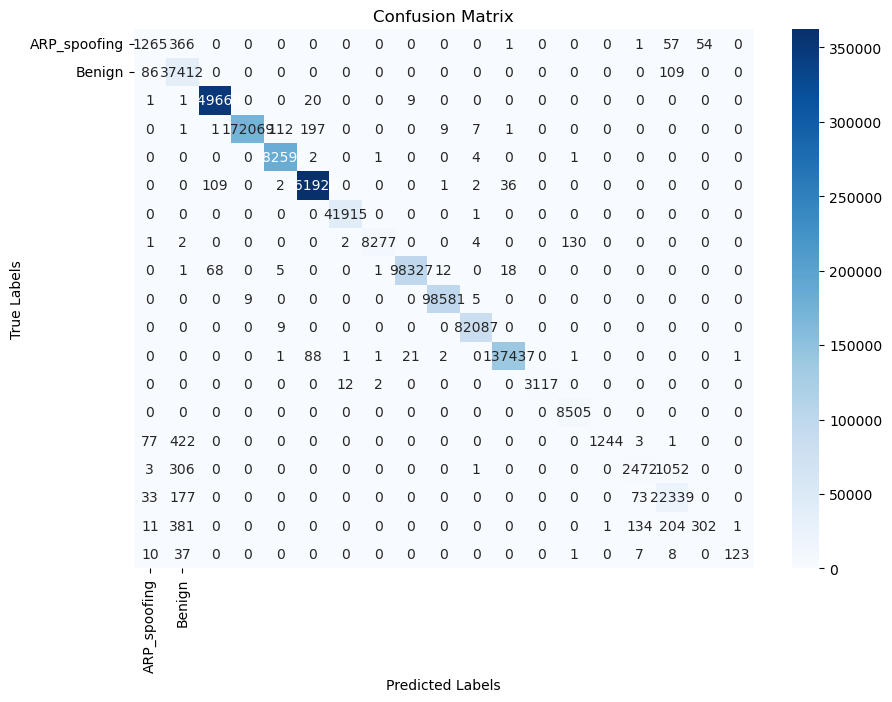

In [22]:
cm_rf_pso_19 = confusion_matrix(y_test_19, y_pred_rf_pso_19)

# get names for confusion matrix
df_19 = pd.DataFrame(rf_pso_report_19)
column_names_19 = df_19.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_pso_19,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_19,
            yticklabels=column_names_19)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Results

In [23]:
# Use if you want to save results in a folder with a specific datetime
#current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
#results_folder = f"results_data_{current_datetime}"

results_folder = 'results_data'

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [24]:
data_to_save = {
    'rf_pso_report_2': rf_pso_report_2,
    'pso_algo_time_2': pso_algo_time_2,
    'rf_pso_train_time_2': rf_pso_train_time_2,
    'rf_pso_pred_time_2': rf_pso_pred_time_2,
    'rf_pso_features_2': rf_pso_features_2,
    'rf_pso_best_pos_2': rf_pso_best_pos_2,
    'cm_rf_pso_2': cm_rf_pso_2,

    'rf_pso_report_6': rf_pso_report_6,
    'pso_algo_time_6': pso_algo_time_6,
    'rf_pso_train_time_6': rf_pso_train_time_6,
    'rf_pso_pred_time_6': rf_pso_pred_time_6,
    'rf_pso_features_6': rf_pso_features_6,
    'rf_pso_best_pos_6': rf_pso_best_pos_6,
    'cm_rf_pso_6': cm_rf_pso_6,

    'rf_pso_report_19': rf_pso_report_19,
    'pso_algo_time_19': pso_algo_time_19,
    'rf_pso_train_time_19': rf_pso_train_time_19,
    'rf_pso_pred_time_19': rf_pso_pred_time_19,
    'rf_pso_features_19': rf_pso_features_19,
    'rf_pso_best_pos_19': rf_pso_best_pos_19,
    'cm_rf_pso_19': cm_rf_pso_19

}

In [25]:
for name, data in data_to_save.items():
    file_path = os.path.join(results_folder, f'{name}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [26]:
for key in data_to_save:
    if isinstance(data_to_save[key], np.integer):
        data_to_save[key] = int(data_to_save[key])
    elif isinstance(data_to_save[key], np.ndarray):
        data_to_save[key] = data_to_save[key].tolist()
        
for name, data in data_to_save.items():
    file_path = os.path.join(results_folder, f'{name}.json') 
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

## Notebook Duration

In [27]:
notebook_end_time = time.time()
print(f"Notebook Duration: {(notebook_end_time - notebook_start_time) / 60} minutes")

Notebook Duration: 67.27044976154963 minutes
